In [1]:
# conda activate bio

# manipulation
import pandas as pd
import numpy as np 
import re 
import os

# viz
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns 

# calculation of properties
from Bio.SeqUtils.ProtParam import ProteinAnalysis 
from protlearn.features import entropy

This notebook shows how the data was collected together with an exploratory data analysis of protein sequences present in the Betalactamase DataBase (BLDB)

# retrive data source

All seqs in BLDB were downloaded on 02/March/2022 using wget

```bash
wget -r -A "*fasta" http://bldb.eu/seq_prot/ > log 2>&1 &

# output log
FINISHED --2022-03-02 20:24:33--
Total wall clock time: 1h 14m 41s
Downloaded: 25828 files, 59M in 27s (2.21 MB/s)
```

Seven seqs were removed from the dataset because they not have a defined betalactamase class (bla_class), they start with "X-" instead of "A-", "B(1,2,3)-", "C-", "D-"). Also, the next seqs were removed because are empty files. This was noted using "ls -laSh" command, and for this reason these modifications are in a new directory called "mod" (raw seqs are in "raw" directory).
- Class a
    - A-SHV-6-prot.fasta
- Class d
    - D-OXA-D1538-prot.fasta
    - D-OXA-D1539-prot.fasta    


Per each bla class:
1. create a directory containing all seqs


2. enter into the dir and list filenames
```bash
ls -1 A-* > ../filenames/filenames_class_a.csv
ls -1 B* > ../filenames/filenames_class_b.csv
ls -1 C* > ../filenames/filenames_class_c.csv
ls -1 D-* > ../filenames/filenames_class_d.csv
```

2. create a multifasta per each (sub)class
```bash
cat class_a/A-* > multifastas/all_class_a.fasta
cat class_b/B1-* > multifastas/all_class_b1.fasta
cat class_b/B2-* > multifastas/all_class_b2.fasta
cat class_b/B3-* > multifastas/all_class_b3.fasta
cat class_b/B* > multifastas/all_class_b.fasta
cat class_c/C* > multifastas/all_class_c.fasta
cat class_d/D-* > multifastas/all_class_d.fastas
```

3. create a table with seqs
```bash
seqkit fx2tab -Q -l -H multifastas/all_class_a.fasta > tabs/all_class_a.csv
seqkit fx2tab -Q -l -H multifastas/all_class_b.fasta > tabs/all_class_b.csv
seqkit fx2tab -Q -l -H multifastas/all_class_c.fasta > tabs/all_class_c.csv
seqkit fx2tab -Q -l -H multifastas/all_class_d.fasta > tabs/all_class_d.csv
```




In [4]:
! tree -L 2 ../data/bldb/  

../data/bldb/
├── mod
│   ├── class_a
│   ├── class_b
│   ├── class_c
│   ├── class_d
│   ├── filenames
│   ├── multifastas
│   ├── readme
│   └── tabs
└── raw
    ├── class_a
    ├── class_b
    ├── class_c
    ├── class_d
    └── class_unk

14 directories, 1 file


In [3]:
# load tables 
class_a = pd.read_csv("../data/bldb/mod/tabs/all_class_a.csv", sep = "\t")
class_b = pd.read_csv("../data/bldb/mod/tabs/all_class_b.csv", sep = "\t")
class_c = pd.read_csv("../data/bldb/mod/tabs/all_class_c.csv", sep = "\t")
class_d = pd.read_csv("../data/bldb/mod/tabs/all_class_d.csv", sep = "\t")

# load filenames  
class_a_files = pd.read_csv("../data/bldb/mod/filenames/filenames_class_a.csv", names=["filename"])
class_b_files = pd.read_csv("../data/bldb/mod/filenames/filenames_class_b.csv", names=["filename"])
class_c_files = pd.read_csv("../data/bldb/mod/filenames/filenames_class_c.csv", names=["filename"])
class_d_files = pd.read_csv("../data/bldb/mod/filenames/filenames_class_d.csv", names=["filename"])

# concat dfs
df_files       = pd.concat([class_a_files, class_b_files, class_c_files, class_d_files])
df             = pd.concat([class_a, class_b, class_c, class_d])
df["filename"] = df_files["filename"]
df

,#name,seq,length,filename
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta
2,EHO64028.1|ACI-3| hypothetical protein HMPREF9...,MKKFCFLFLIICGLMVFSLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-3-prot.fasta
3,AHN92696.1|ACI-4| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMVFCLQGCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-4-prot.fasta
4,AMP55835.1|ACI-5| classA [uncultured bacterium],MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-5-prot.fasta
...,...,...,...,...
2774,GIP03469.1|PAE-P1| putative beta-lactamase Ybx...,MVLKNLKTGQVYTFNSERSKQRFTPESSFKVANALIGLEVKAVADE...,217,D-PAE-P1-prot.fasta
2775,AUW34360.1|RSD1-1| RSD1 family class D beta-la...,MKSYVDKKWMIIFLIVCVSCTSKAIKKEAFPGFKPFFDEYGVQGCF...,271,D-RSD1-1-prot.fasta
2776,AUW34362.1|RSD2-1| class D beta-lactamase RSD2-1,MQTNLIYAMEENAQIKTLFEAADVNATFILYDLQKDTIVGYDKVRS...,257,D-RSD2-1-prot.fasta
2777,AUW34361.1|RSD2-2| class D beta-lactamase RSD2-2,MQTNLIYAMEENAQIKTLFEAADVNATFILYDLQKDTIVGYDKVRS...,252,D-RSD2-2-prot.fasta


In [4]:
# annot fams and proteins
df["protein_name"]   = df["filename"].str.replace("-prot.fasta", "")
df["protein_name"]   = df["protein_name"].str.replace("^A-|^C-|^D-|^B\d-|", "")
df["protein_family"] = df["protein_name"].str.replace("-\w*","")

# annot class andd subclass
filters = [
    df["filename"].str.startswith("A"),
    df["filename"].str.startswith("B"),
    df["filename"].str.startswith("C"),
    df["filename"].str.startswith("D")]

values = ["Class A", "Class B", "Class C", "Class D"]

filters2 = [
    df["filename"].str.startswith("A"),
    df["filename"].str.startswith("B1"),
    df["filename"].str.startswith("B2"),
    df["filename"].str.startswith("B3"),
    df["filename"].str.startswith("C"),
    df["filename"].str.startswith("D")]

values2 = ["Class A", "Class B1", "Class B2", "Class B3", "Class C", "Class D"]

df["bla_class"] = np.select(filters, values)
df["bla_subclass"] = np.select(filters2, values2)
df

/tmp/ipykernel_1026/2509103347.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["protein_name"]   = df["filename"].str.replace("-prot.fasta", "")
/tmp/ipykernel_1026/2509103347.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["protein_name"]   = df["protein_name"].str.replace("^A-|^C-|^D-|^B\d-|", "")
/tmp/ipykernel_1026/2509103347.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df["protein_family"] = df["protein_name"].str.replace("-\w*","")


,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta,ACI-2,ACI,Class A,Class A
2,EHO64028.1|ACI-3| hypothetical protein HMPREF9...,MKKFCFLFLIICGLMVFSLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-3-prot.fasta,ACI-3,ACI,Class A,Class A
3,AHN92696.1|ACI-4| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMVFCLQGCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-4-prot.fasta,ACI-4,ACI,Class A,Class A
4,AMP55835.1|ACI-5| classA [uncultured bacterium],MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-5-prot.fasta,ACI-5,ACI,Class A,Class A
...,...,...,...,...,...,...,...,...
2774,GIP03469.1|PAE-P1| putative beta-lactamase Ybx...,MVLKNLKTGQVYTFNSERSKQRFTPESSFKVANALIGLEVKAVADE...,217,D-PAE-P1-prot.fasta,PAE-P1,PAE,Class D,Class D
2775,AUW34360.1|RSD1-1| RSD1 family class D beta-la...,MKSYVDKKWMIIFLIVCVSCTSKAIKKEAFPGFKPFFDEYGVQGCF...,271,D-RSD1-1-prot.fasta,RSD1-1,RSD1,Class D,Class D
2776,AUW34362.1|RSD2-1| class D beta-lactamase RSD2-1,MQTNLIYAMEENAQIKTLFEAADVNATFILYDLQKDTIVGYDKVRS...,257,D-RSD2-1-prot.fasta,RSD2-1,RSD2,Class D,Class D
2777,AUW34361.1|RSD2-2| class D beta-lactamase RSD2-2,MQTNLIYAMEENAQIKTLFEAADVNATFILYDLQKDTIVGYDKVRS...,252,D-RSD2-2-prot.fasta,RSD2-2,RSD2,Class D,Class D


I create a second column with the information of the respective family, but this is retrieved directly from the header of each seq, not from the filename. For this, i retrive all recognized fams present in [the BLDB](http://bldb.eu/Enzymes.php) and put it into a file called "sub_annot_[bla_class].txt"

In [5]:
# filter sets by subclass
df_a = df[df.bla_class.str.contains("Class A")]
df_b = df[df.bla_class.str.contains("Class B")]
df_c = df[df.bla_class.str.contains("Class C")]
df_d = df[df.bla_class.str.contains("Class D")]

In [6]:
def fam_annot(dataframe, fams_txt): 
    
    """
    a quick function to retreive each fam from headers
    """
    
    # enlist know fams into rx object
    valid = set()
    with open(fams_txt) as f:
        for line in f:
            valid.add(line.rstrip())
    rx="|".join(valid)

    # match fams
    match = 0
    mismatch = 0
    clss = []
    for values in dataframe["#name"]:
        
        # tmp1: text of 2nd to last pipe
        try:
            tmp1 = re.search(r'\|\s*([^\|\s]+)\s*\|[^\|]*$', values).group(1)
        except:
            print(values)
            clss.append("Other")
            continue
        
        # tmp2: match vs rx list
        tmp2 = re.match(f"({rx})\-", tmp1)
        if tmp2:
            clss.append(tmp2.group(1))
            match +=1
        else:
            clss.append("Other")
            mismatch +=1

    # count annots and add clss list as a col
    print(f" Correct annotations:{match}, Others:{mismatch}")
    dataframe["protein_family_header"] = clss

In [7]:
print("############### ANNOTATIONS FOR CLASS A ###############")
fam_annot(df_a, "../data/recognized_fams/sub_annot_a.txt")

print("############### ANNOTATIONS FOR CLASS A ###############")
fam_annot(df_b, "../data/recognized_fams/sub_annot_b.txt")

print("############### ANNOTATIONS FOR CLASS A ###############")
fam_annot(df_c, "../data/recognized_fams/sub_annot_c.txt")

print("############### ANNOTATIONS FOR CLASS A ###############")
fam_annot(df_d, "../data/recognized_fams/sub_annot_d.txt")

/tmp/ipykernel_1026/3927928519.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["protein_family_header"] = clss
/tmp/ipykernel_1026/3927928519.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["protein_family_header"] = clss


############### ANNOTATIONS FOR CLASS A ###############
OKP13200.1|OKP-B-232 OKP family class A broad-spectrum beta-lactamase
 Correct annotations:4594, Others:8719
############### ANNOTATIONS FOR CLASS A ###############
 Correct annotations:1454, Others:1676
############### ANNOTATIONS FOR CLASS A ###############
 Correct annotations:4331, Others:2255
############### ANNOTATIONS FOR CLASS A ###############
 Correct annotations:2680, Others:99


/tmp/ipykernel_1026/3927928519.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["protein_family_header"] = clss
/tmp/ipykernel_1026/3927928519.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["protein_family_header"] = clss


In [8]:
df = pd.concat([df_a, df_b, df_c, df_d])
df

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta,ACI-2,ACI,Class A,Class A,ACI
2,EHO64028.1|ACI-3| hypothetical protein HMPREF9...,MKKFCFLFLIICGLMVFSLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-3-prot.fasta,ACI-3,ACI,Class A,Class A,ACI
3,AHN92696.1|ACI-4| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMVFCLQGCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-4-prot.fasta,ACI-4,ACI,Class A,Class A,ACI
4,AMP55835.1|ACI-5| classA [uncultured bacterium],MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-5-prot.fasta,ACI-5,ACI,Class A,Class A,ACI
...,...,...,...,...,...,...,...,...,...
2774,GIP03469.1|PAE-P1| putative beta-lactamase Ybx...,MVLKNLKTGQVYTFNSERSKQRFTPESSFKVANALIGLEVKAVADE...,217,D-PAE-P1-prot.fasta,PAE-P1,PAE,Class D,Class D,Other
2775,AUW34360.1|RSD1-1| RSD1 family class D beta-la...,MKSYVDKKWMIIFLIVCVSCTSKAIKKEAFPGFKPFFDEYGVQGCF...,271,D-RSD1-1-prot.fasta,RSD1-1,RSD1,Class D,Class D,RSD1
2776,AUW34362.1|RSD2-1| class D beta-lactamase RSD2-1,MQTNLIYAMEENAQIKTLFEAADVNATFILYDLQKDTIVGYDKVRS...,257,D-RSD2-1-prot.fasta,RSD2-1,RSD2,Class D,Class D,RSD2
2777,AUW34361.1|RSD2-2| class D beta-lactamase RSD2-2,MQTNLIYAMEENAQIKTLFEAADVNATFILYDLQKDTIVGYDKVRS...,252,D-RSD2-2-prot.fasta,RSD2-2,RSD2,Class D,Class D,RSD2


# build consensus seqs and add ancestors, varG, and LRA-5

## consensus

Protocol based on: [Consensus sequence design as a general strategy to create hyperstable, biologically active proteins](https://www.pnas.org/doi/10.1073/pnas.1816707116) 
1. remove seqs 30% longer/shorter than the median seq length of the set
2. cluster seqs at 90% identity 
3. buid a msa using mafft v7 webserver 


In [9]:
# basic stats 
medians = df.groupby(['bla_subclass'])['length'].median().values

print(f"class = {df.bla_subclass.unique()}")
print(f"medians = {medians}")
print(f"medians 30% = {medians*0.3}" )

df.groupby(['bla_subclass'])['length'].describe()

class = ['Class A' 'Class B1' 'Class B2' 'Class B3' 'Class C' 'Class D']
medians = [299. 250. 254. 293. 381. 272.]
medians 30% = [ 89.7  75.   76.2  87.9 114.3  81.6]


,count,mean,std,min,25%,50%,75%,max
bla_subclass,,,,,,,,
Class A,13314.0,302.436157,25.210431,95.0,291.0,299.0,311.0,757.0
Class B1,1207.0,252.527755,12.653267,160.0,246.0,250.0,258.5,326.0
Class B2,201.0,247.169154,17.992811,186.0,253.0,254.0,254.0,279.0
Class B3,1722.0,299.721835,33.281796,189.0,288.0,293.0,305.0,793.0
Class C,6586.0,382.835712,14.831118,212.0,377.0,381.0,388.0,730.0
Class D,2779.0,271.611011,18.376086,102.0,265.0,272.0,274.0,475.0


In [10]:
# basic stats for class b
medians = df.groupby(['bla_class'])['length'].median().values

print(f"medians = {medians}")
print(f"medians 30% = {medians*0.3}")

df.groupby(['bla_class'])['length'].describe()

medians = [299. 281. 381. 272.]
medians 30% = [ 89.7  84.3 114.3  81.6]


,count,mean,std,min,25%,50%,75%,max
bla_class,,,,,,,,
Class A,13314.0,302.436157,25.210431,95.0,291.0,299.0,311.0,757.0
Class B,3130.0,278.147923,35.533592,160.0,254.0,281.0,294.0,793.0
Class C,6586.0,382.835712,14.831118,212.0,377.0,381.0,388.0,730.0
Class D,2779.0,271.611011,18.376086,102.0,265.0,272.0,274.0,475.0


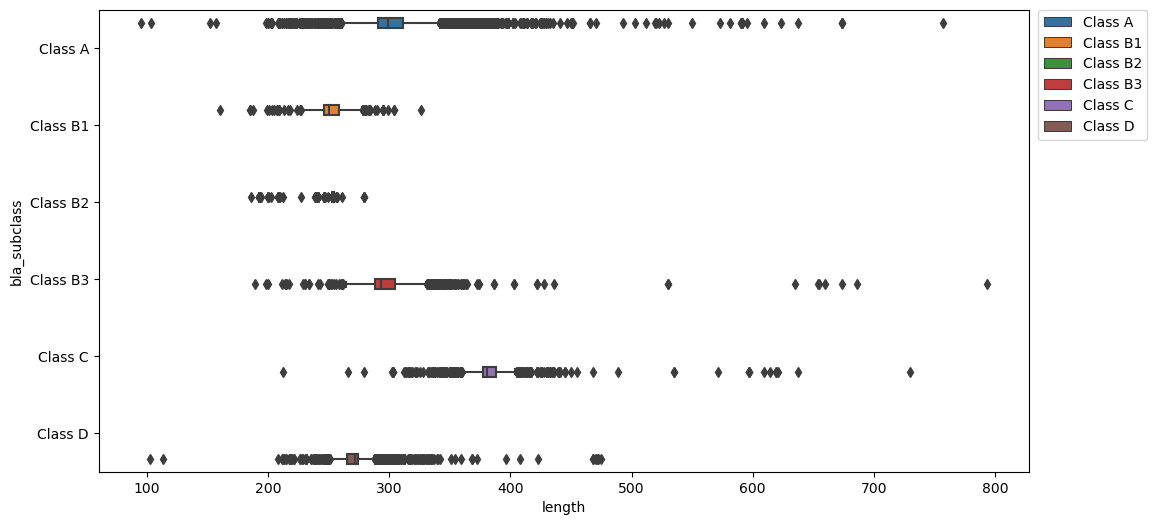

In [11]:
plt.figure(figsize=(12,6))
sns.boxplot(data = df, x = "length", y = "bla_subclass", hue = "bla_subclass")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

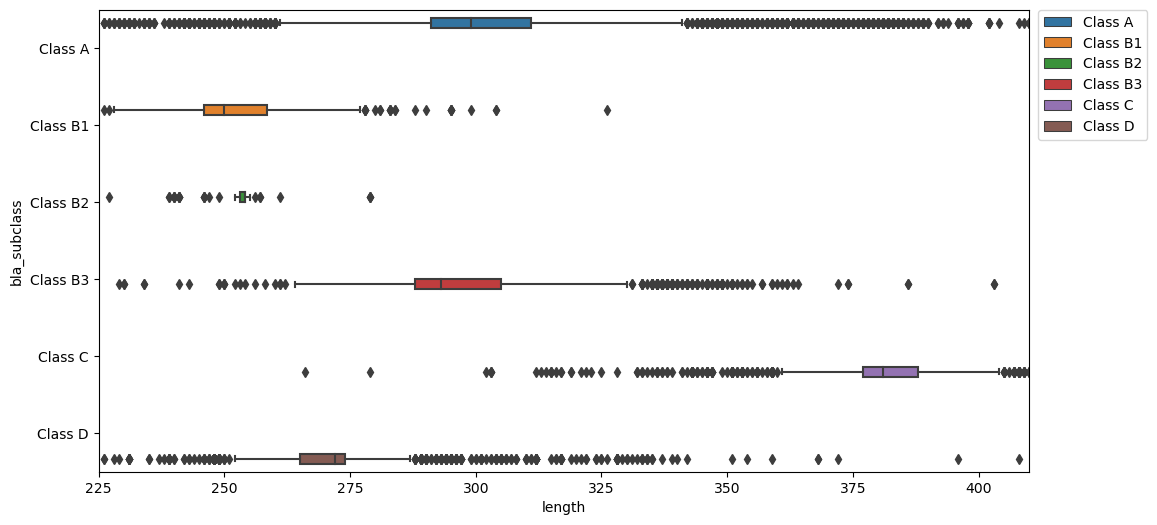

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(data = df, x = "length", y = "bla_subclass", hue = "bla_subclass")
plt.xlim(225, 410)
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

In [13]:
# create dfs
# df_b
df_b1 = df[df.bla_subclass.str.contains("Class B1")]
df_b2 = df[df.bla_subclass.str.contains("Class B2")]
df_b3 = df[df.bla_subclass.str.contains("Class B3")]

# class       = ['Class A' 'Class B'  'Class B1' 'Class B2' 'Class B3' 'Class C'  'Class D']
# medians     = [  299.       281        250.        254.      293.      381.        272.]
# medians 30% = [  89.7       84.3        75.        76.2      87.9      114.3      81.6]

# filter sets by length
a  = df_a[ (df_a.length  >= 209.3) & (df_a.length  <= 388.7)]
b  = df_b[ (df_b.length  >= 196.7) & (df_b.length  <= 365.3)]
b1 = df_b1[(df_b1.length >= 175)   & (df_b1.length <= 325)]
b2 = df_b2[(df_b2.length >= 177.8) & (df_b2.length <= 330.2)]
b3 = df_b3[(df_b3.length >= 205.1) & (df_b3.length <= 380.9)]
c  = df_c[ (df_c.length  >= 266.7) & (df_c.length  <= 495.3)]
d  = df_d[ (df_d.length  >= 190.4) & (df_d.length  <= 353.6)]

# check count diff
print(f"number of  raw seqs: a = {len(df_a)} | b = {len(df_b)} | b1 = {len(df_b1)} | b2 = {len(df_b2)} | b3 = {len(df_b3)} | c = {len(df_c)} | d = {len(df_d)}")
print(f"number of filt seqs: a = {len(a)} | b = {len(b)} | b1 = {len(b1)} | b2 = {len(b2)} | b3 = {len(b3)} | c = {len(c)} | d = {len(d)}")

# export dsets
a[["#name", "seq"]].to_csv("../results/filtSeqByLen/fastas/all_class_a_filtSeqByLen.csv", index = False, sep = "\t")
b[["#name", "seq"]].to_csv("../results/filtSeqByLen/fastas/all_class_b_all_filtSeqByLen.csv", index = False, sep = "\t")
b1[["#name", "seq"]].to_csv("../results/filtSeqByLen/fastas/all_class_b1_filtSeqByLen.csv", index = False, sep = "\t")
b2[["#name", "seq"]].to_csv("../results/filtSeqByLen/fastas/all_class_b2_filtSeqByLen.csv", index = False, sep = "\t")
b3[["#name", "seq"]].to_csv("../results/filtSeqByLen/fastas/all_class_b3_filtSeqByLen.csv", index = False, sep = "\t")
c[["#name", "seq"]].to_csv("../results/filtSeqByLen/fastas/all_class_c_filtSeqByLen.csv", index = False, sep = "\t")
d[["#name", "seq"]].to_csv("../results/filtSeqByLen/fastas/all_class_d_filtSeqByLen.csv", index = False, sep = "\t")

number of  raw seqs: a = 13314 | b = 3130 | b1 = 1207 | b2 = 201 | b3 = 1722 | c = 6586 | d = 2779
number of filt seqs: a = 13203 | b = 3094 | b1 = 1205 | b2 = 201 | b3 = 1702 | c = 6571 | d = 2762


Create fastas and rename  files.


```bash
for file in *csv; do seqkit tab2fx $file > $file.fasta; done
rename "s/.csv.fasta/.fasta/" *.csv.fasta
```

Create clusters at 90% ident using cd-hit (note: -c flag is set to 90% ident by default according to [documentation](http://www.bioinformatics.org/cd-hit/cd-hit-user-guide.pdf))


```bash
cd-hit -i fastas/all_class_a_filtSeqByLen.fasta  -o clust90/all_class_a_filtSeqByLen_clust90.fasta
cd-hit -i fastas/all_class_b1_filtSeqByLen.fasta -o clust90/all_class_b1_filtSeqByLen_clust90.fasta
cd-hit -i fastas/all_class_b2_filtSeqByLen.fasta -o clust90/all_class_b2_filtSeqByLen_clust90.fasta
cd-hit -i fastas/all_class_b3_filtSeqByLen.fasta -o clust90/all_class_b3_filtSeqByLen_clust90.fasta
cd-hit -i fastas/all_class_c_filtSeqByLen.fasta  -o clust90/all_class_c_filtSeqByLen_clust90.fasta
cd-hit -i fastas/all_class_d_filtSeqByLen.fasta  -o clust90/all_class_d_filtSeqByLen_clust90.fasta
```

Concat all subclas b seqs: 


```bash
cat all_class_b*clust90.fasta > all_class_b_filtSeqByLen_clust90.fasta
```

Send seqs to maff_v7 [webserver](https://mafft.cbrc.jp/alignment/server/): 



Trim msas with optimal threshold:


```bash
alignbuddy msa_all_class_a_filtSeqByLen_clust90.fasta  --trimal gappyout > msa_all_class_a_filtSeqByLen_clust90_gappyout.fasta
alignbuddy msa_all_class_b1_filtSeqByLen_clust90.fasta --trimal gappyout > msa_all_class_b1_filtSeqByLen_clust90_gappyout.fasta
alignbuddy msa_all_class_b2_filtSeqByLen_clust90.fasta --trimal gappyout > msa_all_class_b2_filtSeqByLen_clust90_gappyout.fasta
alignbuddy msa_all_class_b3_filtSeqByLen_clust90.fasta --trimal gappyout > msa_all_class_b3_filtSeqByLen_clust90_gappyout.fasta
alignbuddy msa_all_class_b_filtSeqByLen_clust90.fasta  --trimal gappyout > msa_all_class_b_filtSeqByLen_clust90_gappyout.fasta
alignbuddy msa_all_class_c_filtSeqByLen_clust90.fasta  --trimal gappyout > msa_all_class_c_filtSeqByLen_clust90_gappyout.fasta
alignbuddy msa_all_class_d_filtSeqByLen_clust90.fasta  --trimal gappyout > msa_all_class_d_filtSeqByLen_clust90_gappyout.fasta
```

Convert msas into tables and rename it:


```bash
for file in *fasta; do seqkit fx2tab -H -Q $file > $file.csv; done
rename "s/.fasta.csv/.csv/" *.fasta.csv
```

Build consensus seq with weighted approach:


```bash
for file in *fasta; do alignbuddy $file --consensus weighted > cons_$file; done
```

Rename headers of consensus seq according to filename:


```bash
for file in cons*fasta; do 
    awk '/^>/ {gsub(/.fa(sta)?$/,"",FILENAME);printf(">%s\n",FILENAME);next;} {print}' $file > renamed_$file; 
done
```

Note: other class B cons was constructed but by clusterin all class b seqs instead of concatening clust reprs, then, alignbuddy  ../fastas/msa_all_class_b_all_filtSeqByLen_clust90_gappyout.fasta  --consensus weighted > cons_msa_all_class_b_all_filtSeqByLen_clust90_gappyout.fasta was excecuted 

In [14]:
def plot_msa(msa):
    
    """
    Given a MSA in table format, plot the ocupancy
    """
    
    # read. filter data and fill with nans
    name = "../results/filtSeqByLen/msas/fastas/" + msa + ".csv"
    df   = pd.read_csv(name, sep = "\t", names=["id", "seq"])
    df   = df["seq"].apply(lambda x: pd.Series(list(x)))
    df   = df.replace("-", np.nan)
    
    # plot figure
    plt.figure(figsize=(5,3))
    plt.imshow(df.isna(), aspect = "auto", interpolation = "nearest", cmap = "gray")
    plt.xlabel("MSA position")
    plt.ylabel("seq")
    plt.title(msa, size = 8)
    plt.show()

# list msas 
! ls ../results/filtSeqByLen/msas/fastas

gap20  gappyout  raw


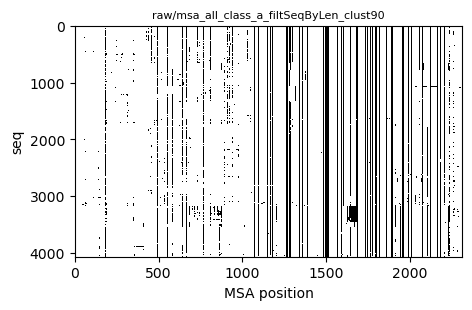

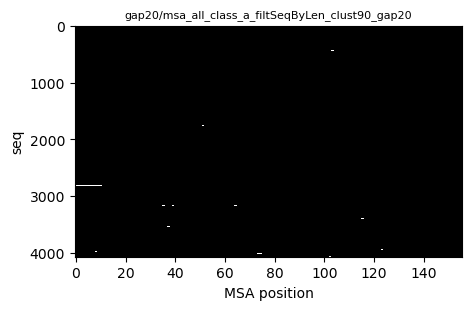

In [15]:
plot_msa("raw/msa_all_class_a_filtSeqByLen_clust90")
plot_msa("gap20/msa_all_class_a_filtSeqByLen_clust90_gap20")

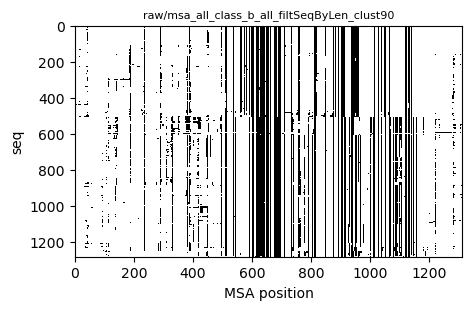

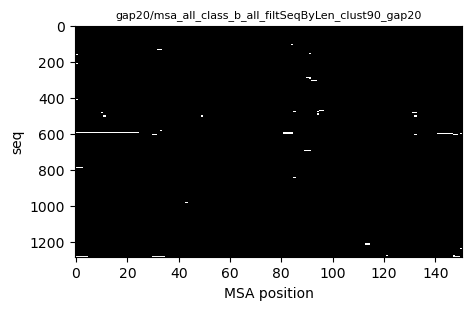

In [16]:
plot_msa("raw/msa_all_class_b_all_filtSeqByLen_clust90")
plot_msa("gap20/msa_all_class_b_all_filtSeqByLen_clust90_gap20")

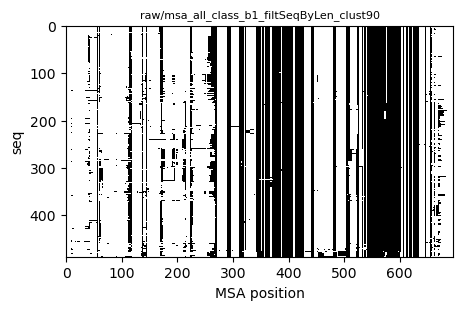

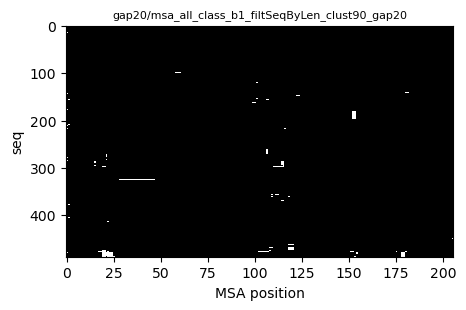

In [17]:
plot_msa("raw/msa_all_class_b1_filtSeqByLen_clust90")
plot_msa("gap20/msa_all_class_b1_filtSeqByLen_clust90_gap20")

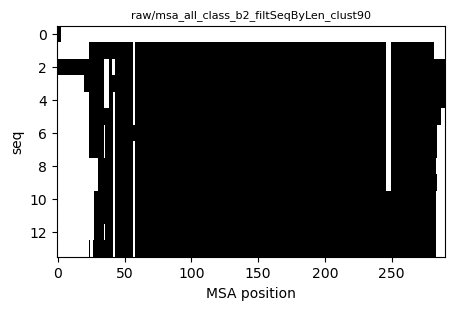

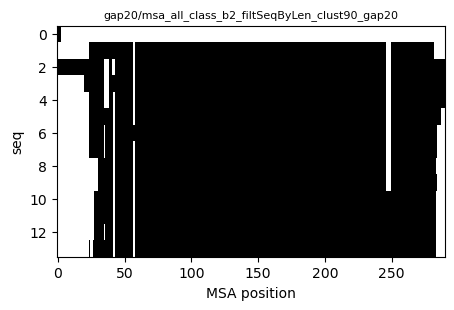

In [18]:
plot_msa("raw/msa_all_class_b2_filtSeqByLen_clust90")
plot_msa("gap20/msa_all_class_b2_filtSeqByLen_clust90_gap20")

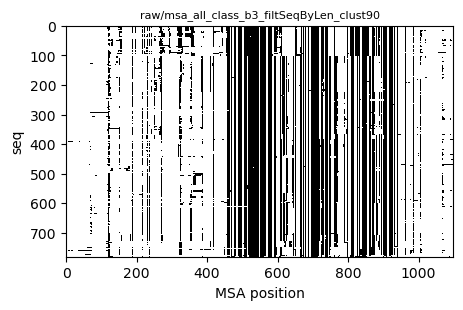

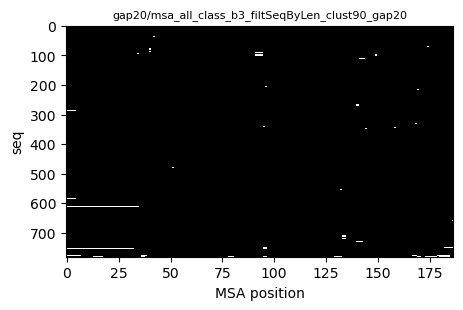

In [19]:
plot_msa("raw/msa_all_class_b3_filtSeqByLen_clust90")
plot_msa("gap20/msa_all_class_b3_filtSeqByLen_clust90_gap20")

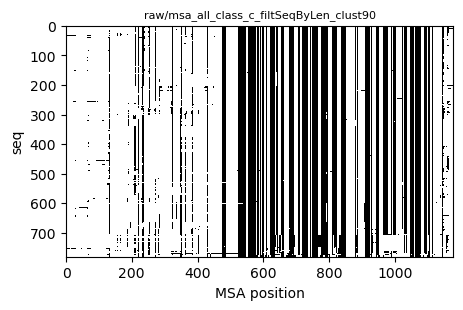

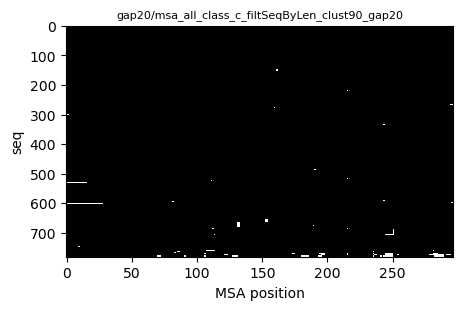

In [20]:
plot_msa("raw/msa_all_class_c_filtSeqByLen_clust90")
plot_msa("gap20/msa_all_class_c_filtSeqByLen_clust90_gap20")

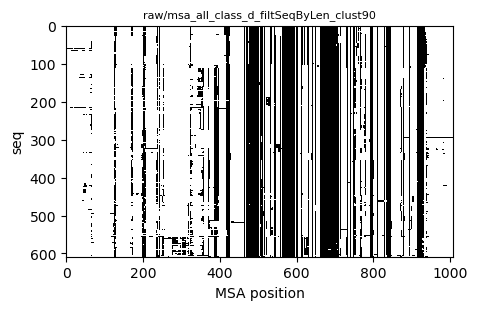

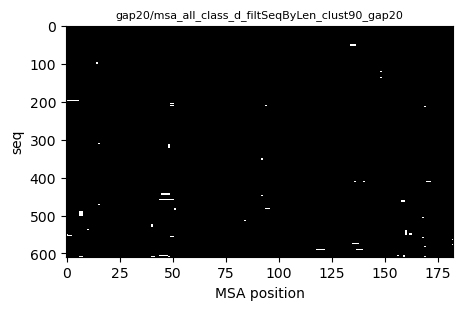

In [21]:
plot_msa("raw/msa_all_class_d_filtSeqByLen_clust90")
plot_msa("gap20/msa_all_class_d_filtSeqByLen_clust90_gap20")

The trimmed (gappyout) msas have a better occupancy, therefore, i choose the cons seqs created from this msas

concat gappyout cons and create a table 
```bash
cat renamed*gappyout.fasta > all_cons_filtSeqByLen_clust90_gappyout.fasta
seqkit fx2tab -l -H -Q all_cons_filtSeqByLen_clust90_gappyout.fasta > all_cons_filtSeqByLen_clust90_gappyout.csv
```


Note: all_cons_filtSeqByLen_clust90_gappyout_v2.fasta is te same file, but with the cons contructed with all class b seqs instead of concatenating individual cluster representatives per subclass. 

In [22]:
cons = pd.read_csv("../results/filtSeqByLen/msas/consensus/renamed/all_cons_filtSeqByLen_clust90_gappyout.csv", sep = "\t")
cons["filename"]              = cons["#name"]
cons["protein_name"]          = cons["#name"]
cons["protein_family"]        = "Consensus"
cons["bla_class"]             = "Consensus"
cons["bla_subclass"]          = "Consensus"
cons["protein_family_header"] = "Consensus"
cons

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header
0,cons_msa_all_class_a_filtSeqByLen_clust90_gapp...,MRRLLALALAAALARLAALERKGGRLGVAALDTTGRTVGYRADERF...,256,cons_msa_all_class_a_filtSeqByLen_clust90_gapp...,cons_msa_all_class_a_filtSeqByLen_clust90_gapp...,Consensus,Consensus,Consensus,Consensus
1,cons_msa_all_class_b1_filtSeqByLen_clust90_gap...,MKLLLLLLLLSCAQDLEITKLSDNVYVHTSYLETEGGKVPSNGLIV...,227,cons_msa_all_class_b1_filtSeqByLen_clust90_gap...,cons_msa_all_class_b1_filtSeqByLen_clust90_gap...,Consensus,Consensus,Consensus,Consensus
2,cons_msa_all_class_b2_filtSeqByLen_clust90_gap...,FKLGGALLALLAAAAGAAAGKLSLKHLKGPVYVVEDDYYVQENSMV...,245,cons_msa_all_class_b2_filtSeqByLen_clust90_gap...,cons_msa_all_class_b2_filtSeqByLen_clust90_gap...,Consensus,Consensus,Consensus,Consensus
3,cons_msa_all_class_b3_filtSeqByLen_clust90_gap...,MKLLLLAAAQEWNKPAPPFRIFGNLYYVGTCGLSAYLITTPEGHIL...,242,cons_msa_all_class_b3_filtSeqByLen_clust90_gap...,cons_msa_all_class_b3_filtSeqByLen_clust90_gap...,Consensus,Consensus,Consensus,Consensus
4,cons_msa_all_class_b_filtSeqByLen_clust90_gapp...,PFRILGNYYVGNGLLITTPKGHILIDTPWDSAPTEALIRWLGFKLK...,162,cons_msa_all_class_b_filtSeqByLen_clust90_gapp...,cons_msa_all_class_b_filtSeqByLen_clust90_gapp...,Consensus,Consensus,Consensus,Consensus
5,cons_msa_all_class_c_filtSeqByLen_clust90_gapp...,MKLAALLLAAAAQLRAIVDAAIKPLMQQYDIPGMAVAVTVDGKPYF...,357,cons_msa_all_class_c_filtSeqByLen_clust90_gapp...,cons_msa_all_class_c_filtSeqByLen_clust90_gapp...,Consensus,Consensus,Consensus,Consensus
6,cons_msa_all_class_d_filtSeqByLen_clust90_gapp...,MKKLLLLLLLACADLFGTFVLYDLKTGKYYVYNKERAETRFSPAST...,232,cons_msa_all_class_d_filtSeqByLen_clust90_gapp...,cons_msa_all_class_d_filtSeqByLen_clust90_gapp...,Consensus,Consensus,Consensus,Consensus


## ancestors, varG cluster and LRA-5 

Ancestral seqs were retrived directly from PDB
- enterobacteria     (ENCA |  [PDB: 3zdj](https://www.rcsb.org/structure/3zdj))
- Gram + and –       (PNCA | [PDB: 4c6y](https://www.rcsb.org/structure/4c6y))
- Gram –             (GNCA | [PDB: 4b88](https://www.rcsb.org/structure/4b88))
- GNCA-TEM1-like     [PDB: 6yrs](https://www.rcsb.org/structure/6yrs))
- (consensus) Risso classA_cons  (ALL-cons | [PDB: 4c75](https://www.rcsb.org/structure/4c75))

create table
```bash
seqkit fx2tab -l -H -Q all_ancestors.fasta > all_ancestors.csv
```

In [23]:
anc = pd.read_csv("../data/ancestors/all_ancestors.csv", sep = "\t")
anc["filename"]              = anc["#name"]
anc["protein_name"]          = anc["#name"]
anc["protein_family"]        = "Ancestral"
anc["bla_class"]             = "Ancestral"
anc["bla_subclass"]          = "Ancestral"
anc["protein_family_header"] = "Ancestral"
anc 

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header
0,ENCA,MHPQTLEQIKESESQLSGRVGMVELDLASGRTLSYRADERFPMMST...,263,ENCA,ENCA,Ancestral,Ancestral,Ancestral,Ancestral
1,GNCA,AAQLSEQLAELEKRSGGRLGVAVLDTATGRRIAYRGDERFPMCSTF...,262,GNCA,GNCA,Ancestral,Ancestral,Ancestral,Ancestral
2,GNCA-TEM-1-like,MAAQLSEQLAELEKRSGGRVGVIVLDTATGRRIAYRGDERFPMMST...,269,GNCA-TEM-1-like,GNCA-TEM-1-like,Ancestral,Ancestral,Ancestral,Ancestral
3,PNCA,AAALSEQLAELEKRSGGRLGVAVLDTATGRRIAYRGDERFPMCSTF...,262,PNCA,PNCA,Ancestral,Ancestral,Ancestral,Ancestral


In [24]:
risso = pd.read_csv("../data/risso_consA/risso_consA.csv", sep = "\t")
risso["filename"]              = risso["#name"]
risso["protein_name"]          = risso["#name"]
risso["protein_family"]        = "Risso cons"
risso["bla_class"]             = "Risso cons"
risso["bla_subclass"]          = "Risso cons"
risso["protein_family_header"] = "Risso cons"
risso 

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header
0,ALL-CON,AAALNDEFAALEKQYGGRLGVYALDTGTGRTIAYRADERFPMCSTF...,262,ALL-CON,ALL-CON,Risso cons,Risso cons,Risso cons,Risso cons


VarG class B seqs were retrived from:
- https://www.ncbi.nlm.nih.gov/protein/?linkname=pubmed_protein&from_uid=28898293

LRA-5 from (putative class A3) from:
- https://www.ncbi.nlm.nih.gov/protein/197296842

create a tble from both 
```bash
seqkit fx2tab -l -H -Q lra_5.fasta > lra_5.csv
seqkit fx2tab -l -H -Q varG_seqs.fasta  > varG_seqs.csv
```

In [25]:
varg = pd.read_csv("../data/varG/varG_seqs.csv", sep = "\t")
varg["filename"]              = "VarG seq"
varg["protein_name"]          = "VarG seq"
varg["protein_family"]        = "VarG"
varg["bla_class"]             = "VarG"
varg["bla_subclass"]          = "VarG"
varg["protein_family_header"] = "VarG"
varg  

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header
0,WP_262839459.1 VarG family subclass B1-like me...,MKLSTLALAPIAAALLTFNASAKGHDHDNQRAIFFPGETVQDTVKV...,374,VarG seq,VarG seq,VarG,VarG,VarG,VarG
1,WP_258463083.1 VarG family subclass B1-like me...,MKLSTLALAPIAAALFAFNVSANGHDHDNQRAIFFHGEKAPIAQTE...,373,VarG seq,VarG seq,VarG,VarG,VarG,VarG
2,WP_256825862.1 VarG family subclass B1-like me...,MKLSILALTPIAAALFTFNVSAKGHDHNNQRAILFPGETVQIEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG
3,WP_253106489.1 VarG family subclass B1-like me...,MKLSTLALTPIAAAVFAFNVSAKGHDHNNQHAILFPGETVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG
4,WP_243357010.1 VarG family subclass B1-like me...,MKRFTFALAPITAALLSFNAGAANHNHSHDQQRAIVFPGETVQSTL...,376,VarG seq,VarG seq,VarG,VarG,VarG,VarG
...,...,...,...,...,...,...,...,...,...
196,WP_000778171.1 MULTISPECIES: VarG family subcl...,MKLSTLALAPIAAALLTFNASAKGHDHDNQRAIFFPGETVQDTVKI...,374,VarG seq,VarG seq,VarG,VarG,VarG,VarG
197,WP_000778170.1 VarG family subclass B1-like me...,MKLSTLALAPIAAALFAFNVSANGHDHDNQRAIFFHGEKAPIAQTE...,373,VarG seq,VarG seq,VarG,VarG,VarG,VarG
198,WP_000701356.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG
199,WP_000701355.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSEVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG


In [26]:
lra = pd.read_csv("../data/lra5/lra_5.csv", sep = "\t")
lra["filename"]              = "lra_5.fasta"
lra["protein_name"]          = "LRA-5"
lra["protein_family"]        = "LRA-5"
lra["bla_class"]             = "Class A"
lra["bla_subclass"]          = "Class A"
lra["protein_family_header"] = "LRA-5"
lra   

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header
0,ACH59002.1 LRA-5 [uncultured bacterium BLR5],MKTIFGKRRQSAVVLITLIAILLASGQPYQSSQVRGAACLPDIIFD...,326,lra_5.fasta,LRA-5,LRA-5,Class A,Class A,LRA-5


## concat all seqs 


In [27]:
df_all = pd.concat([df, cons, anc, risso, varg, lra])
df_all.reset_index(inplace = True, drop = True,)
df_all["seq_id"] = 'seq_' + df_all.index.astype(str)
df_all

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta,ACI-2,ACI,Class A,Class A,ACI,seq_1
2,EHO64028.1|ACI-3| hypothetical protein HMPREF9...,MKKFCFLFLIICGLMVFSLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-3-prot.fasta,ACI-3,ACI,Class A,Class A,ACI,seq_2
3,AHN92696.1|ACI-4| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMVFCLQGCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-4-prot.fasta,ACI-4,ACI,Class A,Class A,ACI,seq_3
4,AMP55835.1|ACI-5| classA [uncultured bacterium],MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-5-prot.fasta,ACI-5,ACI,Class A,Class A,ACI,seq_4
...,...,...,...,...,...,...,...,...,...,...
26018,WP_000778170.1 VarG family subclass B1-like me...,MKLSTLALAPIAAALFAFNVSANGHDHDNQRAIFFHGEKAPIAQTE...,373,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26018
26019,WP_000701356.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26019
26020,WP_000701355.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSEVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26020
26021,WP_000701301.1 VarG family subclass B1-like me...,MKIPNLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26021


# calculate biochem prop

Use ProtLearn and the "ProteinAnalysis" module in biopython to calculate biochem props: 
- https://protlearn.readthedocs.io/en/latest/
- https://biopython.org/docs/1.76/api/Bio.SeqUtils.ProtParam.html
- https://towardsdatascience.com/visualizing-and-analyzing-proteins-in-python-bd99521ccd 

Text(0.5, 1.0, '47 seqs contain X aa')

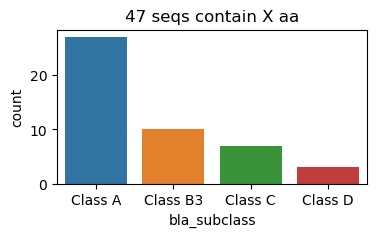

In [28]:
# we need to filter seqs that contain X in their seqs
has_x = df_all[df_all.seq.str.contains("X")]

plt.figure(figsize=(4,2))
sns.countplot(x = has_x.bla_subclass)
plt.title(f"{len(has_x)} seqs contain X aa")

In [29]:
# remove seqs with  X
df_all_not_x = df_all[df_all.seq.str.contains("X") == False]

# enlist seq
seq_list = df_all_not_x["seq"].to_list()

In [30]:
# empty lists
lst_molecular_weight  = []
lst_aromaticity       = []
lst_instability       = []
lst_gravy             = []
lst_isoelectric_point = []
lst_entropy           = []
lst_second_structure  = []


# calculate props 
for seq in seq_list:
    
    # molecular weight
    molecular_weight = ProteinAnalysis(seq).molecular_weight()
    lst_molecular_weight.append(molecular_weight)
    
    # aromaticity
    aromaticity = ProteinAnalysis(seq).aromaticity()
    lst_aromaticity.append(aromaticity)
    
    # instability
    instability = ProteinAnalysis(seq).instability_index()
    lst_instability.append(instability)
    
    # gravy
    gravy = ProteinAnalysis(seq).gravy()
    lst_gravy.append(gravy)
    
    # isoelectric_point
    isoelectric_point = ProteinAnalysis(seq).isoelectric_point()
    lst_isoelectric_point.append(isoelectric_point)
    
    # entropy
    entropy_val = entropy(seq)
    lst_entropy.append(entropy_val)
    
    # lst_second_structure | helix: V, I, Y, F, W, L | Turn: N, P, G, S | sheet: E, M, A, L
    second_structure = ProteinAnalysis(seq).secondary_structure_fraction()
    lst_second_structure.append(second_structure)

In [31]:
# create cols
df_all_not_x["molecular_weight"]  = lst_molecular_weight
df_all_not_x["aromaticity"]       = lst_aromaticity
df_all_not_x["instability"]       = lst_instability
df_all_not_x["gravy"]             = lst_gravy
df_all_not_x["isoelectric_point"] = lst_isoelectric_point
df_all_not_x["entropy"]           = lst_entropy
df_all_not_x["second_structure"]  = lst_second_structure

# split second_structure
df_all_not_x[["helix","turn","sheet"]] = pd.DataFrame(df_all_not_x['second_structure'].tolist(), index = df_all_not_x.index)
df_all_not_x.pop("second_structure")

/tmp/ipykernel_1026/2364032551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_not_x["molecular_weight"]  = lst_molecular_weight
/tmp/ipykernel_1026/2364032551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_not_x["aromaticity"]       = lst_aromaticity
/tmp/ipykernel_1026/2364032551.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

0        (0.29577464788732394, 0.20422535211267606, 0.2...
1        (0.2992957746478873, 0.20774647887323944, 0.23...
2        (0.2992957746478873, 0.20774647887323944, 0.24...
3        (0.29577464788732394, 0.20774647887323944, 0.2...
4        (0.2992957746478873, 0.20422535211267606, 0.24...
                               ...                        
26018    (0.30563002680965146, 0.2439678284182306, 0.24...
26019    (0.32162162162162167, 0.23783783783783785, 0.2...
26020    (0.32162162162162167, 0.23783783783783785, 0.2...
26021    (0.32162162162162167, 0.24324324324324326, 0.2...
26022    (0.29754601226993865, 0.22699386503067484, 0.2...
Name: second_structure, Length: 25976, dtype: object

In [32]:
df_all_not_x

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,molecular_weight,aromaticity,instability,gravy,isoelectric_point,entropy,helix,turn,sheet
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,32041.5642,0.080986,33.895775,-0.316901,8.350993,4.124073,0.295775,0.204225,0.246479
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta,ACI-2,ACI,Class A,Class A,ACI,seq_1,32045.5974,0.084507,33.596831,-0.302465,8.549555,4.127280,0.299296,0.207746,0.239437
2,EHO64028.1|ACI-3| hypothetical protein HMPREF9...,MKKFCFLFLIICGLMVFSLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-3-prot.fasta,ACI-3,ACI,Class A,Class A,ACI,seq_2,32001.5169,0.080986,32.084859,-0.301408,8.395089,4.105261,0.299296,0.207746,0.246479
3,AHN92696.1|ACI-4| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMVFCLQGCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-4-prot.fasta,ACI-4,ACI,Class A,Class A,ACI,seq_3,31983.5281,0.080986,33.217606,-0.305986,8.549555,4.127280,0.295775,0.207746,0.246479
4,AMP55835.1|ACI-5| classA [uncultured bacterium],MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-5-prot.fasta,ACI-5,ACI,Class A,Class A,ACI,seq_4,32067.5981,0.084507,33.061972,-0.310211,8.344933,4.115166,0.299296,0.204225,0.246479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26018,WP_000778170.1 VarG family subclass B1-like me...,MKLSTLALAPIAAALFAFNVSANGHDHDNQRAIFFHGEKAPIAQTE...,373,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26018,41502.2416,0.088472,26.542118,-0.354692,5.746672,4.134886,0.305630,0.243968,0.241287
26019,WP_000701356.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26019,41091.0902,0.091892,29.014081,-0.272973,6.269136,4.130125,0.321622,0.237838,0.224324
26020,WP_000701355.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSEVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26020,41119.0572,0.091892,29.764081,-0.279189,6.083671,4.130703,0.321622,0.237838,0.227027
26021,WP_000701301.1 VarG family subclass B1-like me...,MKIPNLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26021,41147.1136,0.091892,29.014081,-0.292973,6.269136,4.129831,0.321622,0.243243,0.218919


In [33]:
df_all_not_x.columns

Index(['#name', 'seq', 'length', 'filename', 'protein_name', 'protein_family',
       'bla_class', 'bla_subclass', 'protein_family_header', 'seq_id',
       'molecular_weight', 'aromaticity', 'instability', 'gravy',
       'isoelectric_point', 'entropy', 'helix', 'turn', 'sheet'],
      dtype='object')

In [34]:
# select cols to merge
df_all_not_x = df_all_not_x[['seq_id','molecular_weight', 'aromaticity', 'instability', 'gravy',
       'isoelectric_point', 'entropy', 'helix', 'turn', 'sheet']]
df_all_not_x                          

,seq_id,molecular_weight,aromaticity,instability,gravy,isoelectric_point,entropy,helix,turn,sheet
0,seq_0,32041.5642,0.080986,33.895775,-0.316901,8.350993,4.124073,0.295775,0.204225,0.246479
1,seq_1,32045.5974,0.084507,33.596831,-0.302465,8.549555,4.127280,0.299296,0.207746,0.239437
2,seq_2,32001.5169,0.080986,32.084859,-0.301408,8.395089,4.105261,0.299296,0.207746,0.246479
3,seq_3,31983.5281,0.080986,33.217606,-0.305986,8.549555,4.127280,0.295775,0.207746,0.246479
4,seq_4,32067.5981,0.084507,33.061972,-0.310211,8.344933,4.115166,0.299296,0.204225,0.246479
...,...,...,...,...,...,...,...,...,...,...
26018,seq_26018,41502.2416,0.088472,26.542118,-0.354692,5.746672,4.134886,0.305630,0.243968,0.241287
26019,seq_26019,41091.0902,0.091892,29.014081,-0.272973,6.269136,4.130125,0.321622,0.237838,0.224324
26020,seq_26020,41119.0572,0.091892,29.764081,-0.279189,6.083671,4.130703,0.321622,0.237838,0.227027
26021,seq_26021,41147.1136,0.091892,29.014081,-0.292973,6.269136,4.129831,0.321622,0.243243,0.218919


In [35]:
# merge dset 
df_annot_all = pd.merge(df_all, df_all_not_x, on = "seq_id", how = "left")

# set nan val as 0
# df_annot_all = df_annot_all.fillna(0)

#save 
df_annot_all.to_csv("../results/tables/df_annot_all.csv", index = False, sep = "\t")
df_annot_all

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,molecular_weight,aromaticity,instability,gravy,isoelectric_point,entropy,helix,turn,sheet
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,32041.5642,0.080986,33.895775,-0.316901,8.350993,4.124073,0.295775,0.204225,0.246479
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta,ACI-2,ACI,Class A,Class A,ACI,seq_1,32045.5974,0.084507,33.596831,-0.302465,8.549555,4.127280,0.299296,0.207746,0.239437
2,EHO64028.1|ACI-3| hypothetical protein HMPREF9...,MKKFCFLFLIICGLMVFSLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-3-prot.fasta,ACI-3,ACI,Class A,Class A,ACI,seq_2,32001.5169,0.080986,32.084859,-0.301408,8.395089,4.105261,0.299296,0.207746,0.246479
3,AHN92696.1|ACI-4| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMVFCLQGCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-4-prot.fasta,ACI-4,ACI,Class A,Class A,ACI,seq_3,31983.5281,0.080986,33.217606,-0.305986,8.549555,4.127280,0.295775,0.207746,0.246479
4,AMP55835.1|ACI-5| classA [uncultured bacterium],MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-5-prot.fasta,ACI-5,ACI,Class A,Class A,ACI,seq_4,32067.5981,0.084507,33.061972,-0.310211,8.344933,4.115166,0.299296,0.204225,0.246479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26018,WP_000778170.1 VarG family subclass B1-like me...,MKLSTLALAPIAAALFAFNVSANGHDHDNQRAIFFHGEKAPIAQTE...,373,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26018,41502.2416,0.088472,26.542118,-0.354692,5.746672,4.134886,0.305630,0.243968,0.241287
26019,WP_000701356.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26019,41091.0902,0.091892,29.014081,-0.272973,6.269136,4.130125,0.321622,0.237838,0.224324
26020,WP_000701355.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSEVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26020,41119.0572,0.091892,29.764081,-0.279189,6.083671,4.130703,0.321622,0.237838,0.227027
26021,WP_000701301.1 VarG family subclass B1-like me...,MKIPNLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26021,41147.1136,0.091892,29.014081,-0.292973,6.269136,4.129831,0.321622,0.243243,0.218919


In [36]:
#example of NaN vals
df_annot_all[df_annot_all.seq.str.contains("X")].head(2)

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,molecular_weight,aromaticity,instability,gravy,isoelectric_point,entropy,helix,turn,sheet
674,KRF64335.1|AFAM0577-15| class A beta-lactamase,MKSLSNIFSTSTFRKIVPVLFLSCATLVGCSNNNDHAELTKPKKQE...,310,A-AFAM0577-15-prot.fasta,AFAM0577-15,AFAM0577,Class A,Class A,Other,seq_674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,PCJ72005.1|AFAM0751-1| hypothetical protein CO...,MRSIHQTVLNAVAGAIVALCTIVLAGPAFAYDDNLIETIKAVEKRI...,296,A-AFAM0751-1-prot.fasta,AFAM0751-1,AFAM0751,Class A,Class A,Other,seq_835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# check load
df_annot_all = pd.read_csv("../results/tables/df_annot_all.csv", sep = "\t")
df_annot_all

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,molecular_weight,aromaticity,instability,gravy,isoelectric_point,entropy,helix,turn,sheet
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,32041.5642,0.080986,33.895775,-0.316901,8.350993,4.124073,0.295775,0.204225,0.246479
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta,ACI-2,ACI,Class A,Class A,ACI,seq_1,32045.5974,0.084507,33.596831,-0.302465,8.549555,4.127280,0.299296,0.207746,0.239437
2,EHO64028.1|ACI-3| hypothetical protein HMPREF9...,MKKFCFLFLIICGLMVFSLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-3-prot.fasta,ACI-3,ACI,Class A,Class A,ACI,seq_2,32001.5169,0.080986,32.084859,-0.301408,8.395089,4.105261,0.299296,0.207746,0.246479
3,AHN92696.1|ACI-4| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMVFCLQGCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-4-prot.fasta,ACI-4,ACI,Class A,Class A,ACI,seq_3,31983.5281,0.080986,33.217606,-0.305986,8.549555,4.127280,0.295775,0.207746,0.246479
4,AMP55835.1|ACI-5| classA [uncultured bacterium],MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-5-prot.fasta,ACI-5,ACI,Class A,Class A,ACI,seq_4,32067.5981,0.084507,33.061972,-0.310211,8.344933,4.115166,0.299296,0.204225,0.246479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26018,WP_000778170.1 VarG family subclass B1-like me...,MKLSTLALAPIAAALFAFNVSANGHDHDNQRAIFFHGEKAPIAQTE...,373,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26018,41502.2416,0.088472,26.542118,-0.354692,5.746672,4.134886,0.305630,0.243968,0.241287
26019,WP_000701356.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26019,41091.0902,0.091892,29.014081,-0.272973,6.269136,4.130125,0.321622,0.237838,0.224324
26020,WP_000701355.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSEVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26020,41119.0572,0.091892,29.764081,-0.279189,6.083671,4.130703,0.321622,0.237838,0.227027
26021,WP_000701301.1 VarG family subclass B1-like me...,MKIPNLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26021,41147.1136,0.091892,29.014081,-0.292973,6.269136,4.129831,0.321622,0.243243,0.218919


[Text(0, 0, '13315'),
 Text(0, 0, '3130'),
 Text(0, 0, '6586'),
 Text(0, 0, '2779'),
 Text(0, 0, '7'),
 Text(0, 0, '4'),
 Text(0, 0, '1'),
 Text(0, 0, '201')]

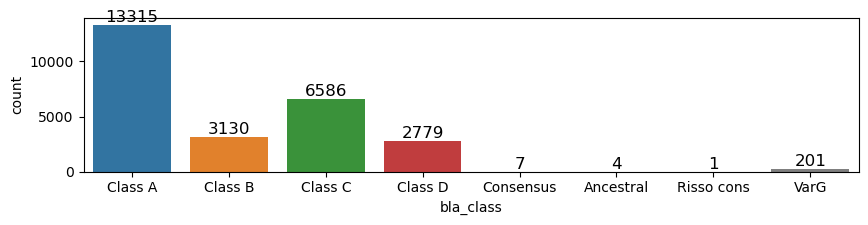

In [38]:
plt.figure(figsize=(10,2))
ax = sns.countplot(x = df_annot_all.bla_class)
ax.bar_label(ax.containers[0], size=12)

In [39]:
df_annot_all.bla_class.unique()

array(['Class A', 'Class B', 'Class C', 'Class D', 'Consensus',
       'Ancestral', 'Risso cons', 'VarG'], dtype=object)

In [40]:
#export dfs
df_annot_a = df_annot_all[df_annot_all.bla_class.str.contains("Class A")]
df_annot_a[["seq_id", "seq"]].to_csv("../results/tables/df_annot_a.csv", index = False, sep = "\t")

df_annot_b = df_annot_all[df_annot_all.bla_class.str.contains("Class B")]
df_annot_b[["seq_id", "seq"]].to_csv("../results/tables/df_annot_b.csv", index = False, sep = "\t")

df_annot_c = df_annot_all[df_annot_all.bla_class.str.contains("Class C")]
df_annot_c[["seq_id", "seq"]].to_csv("../results/tables/df_annot_c.csv", index = False, sep = "\t")

df_annot_d = df_annot_all[df_annot_all.bla_class.str.contains("Class D")]
df_annot_d[["seq_id", "seq"]].to_csv("../results/tables/df_annot_d.csv", index = False, sep = "\t")

df_annot_cons = df_annot_all[df_annot_all.bla_class.str.contains("Consensus")]
df_annot_cons[["seq_id", "seq"]].to_csv("../results/tables/df_annot_cons.csv", index = False, sep = "\t")

df_annot_anc = df_annot_all[df_annot_all.bla_class.str.contains("Ancestral")]
df_annot_anc[["seq_id", "seq"]].to_csv("../results/tables/df_annot_anc.csv", index = False, sep = "\t")

df_annot_risso = df_annot_all[df_annot_all.bla_class.str.contains("Risso cons")]
df_annot_risso[["seq_id", "seq"]].to_csv("../results/tables/df_annot_risso.csv", index = False, sep = "\t")

df_annot_varg = df_annot_all[df_annot_all.bla_class.str.contains("VarG")]
df_annot_varg[["seq_id", "seq"]].to_csv("../results/tables/df_annot_varg.csv", index = False, sep = "\t")

In [41]:
! ls ../results/tables/

df_annot_a.csv	  df_annot_b.csv     df_annot_d.csv	 fastas
df_annot_all.csv  df_annot_c.csv     df_annot_risso.csv
df_annot_anc.csv  df_annot_cons.csv  df_annot_varg.csv


# Is cluster representative

In [42]:
# this code only was re-used to export the seqs used to buid a cons, but, using the seq_id as header
# because in the first try, the seqs were exported with #name col
# class
df_a = df_annot_all[df_annot_all.bla_class.str.contains("Class A")]
df_c = df_annot_all[df_annot_all.bla_class.str.contains("Class C")]
df_d = df_annot_all[df_annot_all.bla_class.str.contains("Class D")]

# create dfs
df_b1 = df_annot_all[df_annot_all.bla_subclass.str.contains("Class B1")]
df_b2 = df_annot_all[df_annot_all.bla_subclass.str.contains("Class B2")]
df_b3 = df_annot_all[df_annot_all.bla_subclass.str.contains("Class B3")]

# class            A      B1    B2      B3      C        D
# medians     = [ 299.0   250   254.0   293.0    381.0   272.0]
# medians 30% = [  89.7    75    76.2    87.9    114.3    81.6]

# filter sets by length
a  = df_a[ (df_a.length  >= 209.3) & (df_a.length  <= 388.7)]
b1 = df_b1[(df_b1.length >= 175)   & (df_b1.length <= 325)]
b2 = df_b2[(df_b2.length >= 177.8) & (df_b2.length <= 330.2)]
b3 = df_b3[(df_b3.length >= 205.1) & (df_b3.length <= 380.9)]
c  = df_c[ (df_c.length  >= 266.7) & (df_c.length  <= 495.3)]
d  = df_d[ (df_d.length  >= 190.4) & (df_d.length  <= 353.6)]

# check count diff
print(f"number of  raw seqs: a = {len(df_a)} | b1 = {len(df_b1)} | b2 = {len(df_b2)} | b3 = {len(df_b3)} | c = {len(df_c)} | d = {len(df_d)}")
print(f"number of filt seqs: a = {len(a)} | b1 = {len(b1)} | b2 = {len(b2)} | b3 = {len(b3)} | c = {len(c)} | d = {len(d)}")

# export dsets
a[["seq_id", "seq"]].to_csv("../results/filtSeqByLen/tables/simpid/all_class_a_filtSeqByLen_simpid.csv", index = False, sep = "\t")
b1[["seq_id", "seq"]].to_csv("../results/filtSeqByLen/tables/simpid/all_class_b1_filtSeqByLen_simpid.csv", index = False, sep = "\t")
b2[["seq_id", "seq"]].to_csv("../results/filtSeqByLen/tables/simpid/all_class_b2_filtSeqByLen_simpid.csv", index = False, sep = "\t")
b3[["seq_id", "seq"]].to_csv("../results/filtSeqByLen/tables/simpid/all_class_b3_filtSeqByLen_simpid.csv", index = False, sep = "\t")
c[["seq_id", "seq"]].to_csv("../results/filtSeqByLen/tables/simpid/all_class_c_filtSeqByLen_simpid.csv", index = False, sep = "\t")
d[["seq_id", "seq"]].to_csv("../results/filtSeqByLen/tables/simpid/all_class_d_filtSeqByLen_simpid.csv", index = False, sep = "\t")

number of  raw seqs: a = 13315 | b1 = 1207 | b2 = 201 | b3 = 1722 | c = 6586 | d = 2779
number of filt seqs: a = 13204 | b1 = 1205 | b2 = 201 | b3 = 1702 | c = 6571 | d = 2762


In [43]:
# read data 
clust_path = "../results/filtSeqByLen/tables/simpid/clust90/tables/"

li = []

for file in os.listdir(clust_path):
    filename = clust_path + file
    csv = pd.read_csv(filename, index_col=None, header=0,  sep = "\t")
    li.append(csv)

cluster_repr = pd.concat(li, axis=0, ignore_index=True)
cluster_repr = cluster_repr[["#name"]]

cluster_repr_lst = cluster_repr["#name"].to_list()

In [44]:
df_annot_all[df_annot_all["seq_id"].isin(cluster_repr_lst)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,molecular_weight,aromaticity,instability,gravy,isoelectric_point,entropy,helix,turn,sheet
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,32041.5642,0.080986,33.895775,-0.316901,8.350993,4.124073,0.295775,0.204225,0.246479
7,gi|2992469|gb|AAC09015.1|AER-1| carbenicillin-...,MYVLSVEKPTLRNKFAAGIGVVLVCVVASFIPTPVFALDTTKLIQA...,304,A-AER-1-prot.fasta,AER-1,AER,Class A,Class A,AER,seq_7,32427.6053,0.065789,32.011842,0.009211,6.744935,4.060672,0.296053,0.253289,0.250000
9,gi|40950501|gb|AAR97884.1|AFA-1| class A beta-...,MKIKPFLFGLIVLANNAIAGSLTQNIEAIELSSGGYIGVSVLNTET...,283,A-AFA-1-prot.fasta,AFA-1,AFA,Class A,Class A,AFA,seq_9,31181.3025,0.067138,43.643110,-0.210954,5.549100,4.099215,0.289753,0.261484,0.250883
27,CUS46161.1|AFAM0002-1| Beta-lactamase [hydroth...,MTLLAAALCACGHDTSRHLTLIPAAAVRPPYQVVVPVPPPTPRPVP...,367,A-AFAM0002-1-prot.fasta,AFAM0002-1,AFAM0002,Class A,Class A,Other,seq_27,39198.4523,0.059946,40.813896,-0.132153,9.910161,3.997616,0.267030,0.242507,0.272480
28,EQD65118.1|AFAM0003-1| CTX-M-1-derivative beta...,MGMLSRRQVLKGMALGVAAGALRTVPVRAASLASALHAQFARIESQ...,301,A-AFAM0003-1-prot.fasta,AFAM0003-1,AFAM0003,Class A,Class A,Other,seq_28,31611.8801,0.039867,30.509635,0.037874,10.471293,3.858103,0.259136,0.222591,0.352159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25804,GIP03469.1|PAE-P1| putative beta-lactamase Ybx...,MVLKNLKTGQVYTFNSERSKQRFTPESSFKVANALIGLEVKAVADE...,217,D-PAE-P1-prot.fasta,PAE-P1,PAE,Class D,Class D,Other,seq_25804,24962.1621,0.110599,30.710599,-0.446083,6.347290,4.127949,0.308756,0.179724,0.271889
25805,AUW34360.1|RSD1-1| RSD1 family class D beta-la...,MKSYVDKKWMIIFLIVCVSCTSKAIKKEAFPGFKPFFDEYGVQGCF...,271,D-RSD1-1-prot.fasta,RSD1-1,RSD1,Class D,Class D,RSD1,seq_25805,31629.8315,0.132841,36.210738,-0.377491,5.887860,4.202824,0.339483,0.221402,0.214022
25806,AUW34362.1|RSD2-1| class D beta-lactamase RSD2-1,MQTNLIYAMEENAQIKTLFEAADVNATFILYDLQKDTIVGYDKVRS...,257,D-RSD2-1-prot.fasta,RSD2-1,RSD2,Class D,Class D,RSD2,seq_25806,28995.0452,0.105058,38.777043,-0.246693,6.768410,4.120463,0.330739,0.217899,0.272374
25808,ACZ07185.1|STD-1| class D beta-lactamase,MEILFSFLLSFVFSVNTMVSNSNVNLQKIFDENKITGSVTIYDYKN...,264,D-STD-1-prot.fasta,STD-1,STD,Class D,Class D,STD,seq_25808,31525.6694,0.151515,37.602689,-0.455303,5.342320,3.966123,0.375000,0.212121,0.261364


In [45]:
# label cluster representatives 
filters = [
      df_annot_all["seq_id"].isin(cluster_repr_lst), 
    (~df_annot_all["seq_id"].isin(cluster_repr_lst))]
values = ["Yes", "No"]

df_annot_all["is_clust90_rep"]  = np.select(filters, values)
df_annot_all

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,molecular_weight,aromaticity,instability,gravy,isoelectric_point,entropy,helix,turn,sheet,is_clust90_rep
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,32041.5642,0.080986,33.895775,-0.316901,8.350993,4.124073,0.295775,0.204225,0.246479,Yes
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta,ACI-2,ACI,Class A,Class A,ACI,seq_1,32045.5974,0.084507,33.596831,-0.302465,8.549555,4.127280,0.299296,0.207746,0.239437,No
2,EHO64028.1|ACI-3| hypothetical protein HMPREF9...,MKKFCFLFLIICGLMVFSLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-3-prot.fasta,ACI-3,ACI,Class A,Class A,ACI,seq_2,32001.5169,0.080986,32.084859,-0.301408,8.395089,4.105261,0.299296,0.207746,0.246479,No
3,AHN92696.1|ACI-4| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMVFCLQGCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-4-prot.fasta,ACI-4,ACI,Class A,Class A,ACI,seq_3,31983.5281,0.080986,33.217606,-0.305986,8.549555,4.127280,0.295775,0.207746,0.246479,No
4,AMP55835.1|ACI-5| classA [uncultured bacterium],MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-5-prot.fasta,ACI-5,ACI,Class A,Class A,ACI,seq_4,32067.5981,0.084507,33.061972,-0.310211,8.344933,4.115166,0.299296,0.204225,0.246479,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26018,WP_000778170.1 VarG family subclass B1-like me...,MKLSTLALAPIAAALFAFNVSANGHDHDNQRAIFFHGEKAPIAQTE...,373,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26018,41502.2416,0.088472,26.542118,-0.354692,5.746672,4.134886,0.305630,0.243968,0.241287,No
26019,WP_000701356.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26019,41091.0902,0.091892,29.014081,-0.272973,6.269136,4.130125,0.321622,0.237838,0.224324,No
26020,WP_000701355.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSEVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26020,41119.0572,0.091892,29.764081,-0.279189,6.083671,4.130703,0.321622,0.237838,0.227027,No
26021,WP_000701301.1 VarG family subclass B1-like me...,MKIPNLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26021,41147.1136,0.091892,29.014081,-0.292973,6.269136,4.129831,0.321622,0.243243,0.218919,No


# Add taxonomy

Use the next github repo to retrive the taxonomy of each seq, but add modifications in the code to work with the RS207 version of GTDB (i.e. consider the new names of [metadata files](https://github.com/hbckleikamp/GTDB2DIAMOND ): ar53_taxonom and bac120_taxonomy):


Download and extract the data, then, organize files into GTDB and GTDB-metadata dirs
```bash
wget https://data.gtdb.ecogenomic.org/releases/latest/genomic_files_reps/gtdb_proteins_aa_reps.tar.gz . > log 2>&1 &
wget https://data.gtdb.ecogenomic.org/releases/latest/ar53_taxonomy.tsv.gz
wget https://data.gtdb.ecogenomic.org/releases/latest/bac120_taxonomy.tsv.gz
tar -xvf *.tar.gz
```

GTDB dir must have a dir called "protein_faa_reps" with archaea and bacteria genomes. Then, run "GTDB_protein_rename.py" in the same dir as GTDB and GTDB-metadata dirs. This rename all headers in GTDB proteome with the respective genome source. Example with genome GCA_000008085.1:

```bash
head GTDB/protein_faa_reps/archaea/*GCA_000008085.1*
```

>AE017199.1_1 # 1 # 879 # -1 # ID=1_1;partial=10;start_type=ATG;rbs_motif=None;rbs_spacer=None;gc_cont=0.273
MRLLLELKALNSIDKKQLSNYLIQGFIYNILKNTEYSWLHNWKKEKYFNFTLIPKKDIIE ...

```bash
head GTDB/renamed/*GCA_000008085.1*
```

>AE017199.1_1_GB_GCA_000008085.1 AE017199.1_1 # 1 # 879 # -1 # ID=1_1;partial=10;start_type=ATG;rbs_motif=None;rbs_spacer=None;gc_cont=0.273
MRLLLELKALNSIDKKQLSNYLIQGFIYNILKNTEYSWLHNWKKEKYFNFTLIPKKDIIE ...



Remove files to save space

```bash
rm -r GTDB/protein_faa_reps/*
```

Run "GTDB_protein_merge.py" and remove files to save space
```bash
rm -r protein_faa_reps/ renamed/
```

Make diamond DB and run diamond (also, remove files in GTDB dir and only keep the diamond db file)
```bash
diamond2 makedb --in GTDB_merged.fasta -d diamond_gtdbR207_proteome/diamond_gtdbR207_proteome
diamond2 blastp -d ../diamond_gtdbR207_proteome.dmnd -q df_annot_all.fasta -o diamond_output.tsv
```

Run "GTDB_protein_LCA.py" and remove redundancy in the output

```bash
awk '!seen[$0]++' diamond_lca.tsv > diamond_lca_nonredu.tsv
```

Note: this was runned on FOS compute server (~500RAM + 2 intel xeon)

In [46]:
# load tax
taxo = ["seq_id","bitscore","Domain","Phylum","Class","Order","Family","Genus","Species"]
df_tax = pd.read_csv("../results/tax/diamond_lca_nonredu.tsv", sep = "\t", names = taxo)
df_tax

,seq_id,bitscore,Domain,Phylum,Class,Order,Family,Genus,Species
0,seq_0,569.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
1,seq_1,563.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
2,seq_2,566.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
3,seq_3,566.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
4,seq_4,566.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
26017,seq_26018,659.0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,NaN,NaN,NaN
26018,seq_26019,753.0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Vibrionaceae,g__Vibrio,s__Vibrio mimicus
26019,seq_26020,753.0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Vibrionaceae,g__Vibrio,s__Vibrio mimicus
26020,seq_26021,756.0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Vibrionaceae,g__Vibrio,s__Vibrio mimicus


Note that the next seq was not considered by diamond in the first run because it correspond to a human ion channel

In [47]:
# seq_8798 
df_annot_all[~df_annot_all.seq_id.isin(df_tax.seq_id.to_list())]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,molecular_weight,aromaticity,instability,gravy,isoelectric_point,entropy,helix,turn,sheet,is_clust90_rep
8798,AAB49182.1|BcI-532| acid-sensing ion channel 2...,MDLKESPSEGSLQPSSIQIFANTSTLHGIRHIFVYGPLTIRRVLWA...,512,A-BcI-532-prot.fasta,BcI-532,BcI,Class A,Class A,BcI,seq_8798,57708.3492,0.099609,44.882617,-0.165039,5.073471,4.165209,0.326172,0.214844,0.275391,No


In [48]:
# check wich seqs have an incomplete annotation
df_tax[df_tax.Phylum.isna()]

,seq_id,bitscore,Domain,Phylum,Class,Order,Family,Genus,Species
0,seq_0,569.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
1,seq_1,563.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
2,seq_2,566.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
3,seq_3,566.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
4,seq_4,566.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
25811,seq_25812,258.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
25812,seq_25813,140.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
25814,seq_25815,281.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
25815,seq_25816,437.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN


This 1201 seqs no have hit that provides an extensive classification. Export this seqs, convert to fasta and run diamond again, bu with the flag "--sensitive" 

In [49]:
mismatch_ids = df_tax[df_tax.Phylum.isna()].seq_id.to_list()
mismatch_ids.append("seq_8798")
print(f" length of elements {len(mismatch_ids)}")
mismatch_ids[-2:]

 length of elements 1201


['seq_25820', 'seq_8798']

In [50]:
# df_annot_all[df_annot_all.seq_id.isin(mismatch_ids)][["seq_id", "seq"]].to_csv("/home/gama/desktop/mismatch_seqs.csv", index = False, sep = "\t")

Again, this had the same result. So ... F :/ 

In [51]:
# merge dfs
df_annot_tax = pd.merge(df_annot_all, df_tax, on = "seq_id", how = "left")
df_annot_tax.to_csv("../results/tables/df_annot_all.csv", index = False, sep = "\t")
df_annot_tax

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,sheet,is_clust90_rep,bitscore,Domain,Phylum,Class,Order,Family,Genus,Species
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,...,0.246479,Yes,569.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta,ACI-2,ACI,Class A,Class A,ACI,seq_1,...,0.239437,No,563.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
2,EHO64028.1|ACI-3| hypothetical protein HMPREF9...,MKKFCFLFLIICGLMVFSLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-3-prot.fasta,ACI-3,ACI,Class A,Class A,ACI,seq_2,...,0.246479,No,566.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
3,AHN92696.1|ACI-4| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMVFCLQGCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-4-prot.fasta,ACI-4,ACI,Class A,Class A,ACI,seq_3,...,0.246479,No,566.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
4,AMP55835.1|ACI-5| classA [uncultured bacterium],MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-5-prot.fasta,ACI-5,ACI,Class A,Class A,ACI,seq_4,...,0.246479,No,566.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26018,WP_000778170.1 VarG family subclass B1-like me...,MKLSTLALAPIAAALFAFNVSANGHDHDNQRAIFFHGEKAPIAQTE...,373,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26018,...,0.241287,No,659.0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,NaN,NaN,NaN
26019,WP_000701356.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26019,...,0.224324,No,753.0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Vibrionaceae,g__Vibrio,s__Vibrio mimicus
26020,WP_000701355.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSEVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26020,...,0.227027,No,753.0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Vibrionaceae,g__Vibrio,s__Vibrio mimicus
26021,WP_000701301.1 VarG family subclass B1-like me...,MKIPNLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26021,...,0.218919,No,756.0,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Vibrionaceae,g__Vibrio,s__Vibrio mimicus


In [52]:
# example of the only seq that have no tax annot because it correspond to a human ion channel 
# this was not expected since the BLDB is manually annotated by 2 teams
df_annot_tax[df_annot_tax["#name"].str.contains("AAB49182.1")]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,sheet,is_clust90_rep,bitscore,Domain,Phylum,Class,Order,Family,Genus,Species
8798,AAB49182.1|BcI-532| acid-sensing ion channel 2...,MDLKESPSEGSLQPSSIQIFANTSTLHGIRHIFVYGPLTIRRVLWA...,512,A-BcI-532-prot.fasta,BcI-532,BcI,Class A,Class A,BcI,seq_8798,...,0.275391,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# SignalP

Preds were realized using the webserver of signalPv6 using the next params: Organism = Other, Output format = Short, Model mode = Slow

In [53]:
# load data 
df = pd.read_csv("../results/tables/df_annot_all.csv", sep = "\t")
df.head(2)

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,sheet,is_clust90_rep,bitscore,Domain,Phylum,Class,Order,Family,Genus,Species
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,...,0.246479,Yes,569.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta,ACI-2,ACI,Class A,Class A,ACI,seq_1,...,0.239437,No,563.0,d__Bacteria,NaN,NaN,NaN,NaN,NaN,NaN


Merge all signalP preds and inspect/clean with excel
```bash
cat ~gama/bla_analysis/results/signalp6/preds/*/*txt > man_curat_preds.csv
```

In [54]:
df_sigp  = pd.read_csv("../results/signalp6/man_curat_preds.csv")
df_sigp.rename(columns={'# ID': 'seq_id'}, inplace=True)
df_sigp

,seq_id,Prediction,OTHER,SP(Sec/SPI),LIPO(Sec/SPII),TAT(Tat/SPI),TATLIPO(Sec/SPII),PILIN(Sec/SPIII),CS Position
0,seq_0,LIPO,0.000157,0.499448,0.500170,0.000095,0.000088,0.000081,CS pos: 21-22. Pr: 0.4839
1,seq_1,LIPO,0.000125,0.499552,0.500104,0.000080,0.000071,0.000069,CS pos: 21-22. Pr: 0.4476
2,seq_10,SP,0.000344,0.998690,0.000311,0.000252,0.000213,0.000201,CS pos: 19-20. Pr: 0.9754
3,seq_100,NO_SP,1.000014,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
4,seq_1000,SP,0.000184,0.999194,0.000167,0.000175,0.000137,0.000139,CS pos: 25-26. Pr: 0.9017
...,...,...,...,...,...,...,...,...,...
26018,seq_9995,SP,0.000185,0.999239,0.000150,0.000165,0.000129,0.000129,CS pos: 27-28. Pr: 0.9777
26019,seq_9996,SP,0.000252,0.999018,0.000246,0.000192,0.000150,0.000154,CS pos: 22-23. Pr: 0.9761
26020,seq_9997,SP,0.000248,0.999036,0.000244,0.000190,0.000150,0.000150,CS pos: 22-23. Pr: 0.9761
26021,seq_9998,SP,0.000250,0.999011,0.000245,0.000191,0.000150,0.000153,CS pos: 22-23. Pr: 0.9762


In [55]:
# all seqs are in df_sigp
df[~df.seq_id.isin(df_sigp.seq_id)]

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,sheet,is_clust90_rep,bitscore,Domain,Phylum,Class,Order,Family,Genus,Species


Merge all fastas with pruned seqs and convert to a table

```bash
cat */*fasta > all_seq_wo_sigpept.fasta
```

In [56]:
df_prunseq = pd.read_csv("../results/signalp6/all_seq_wo_sigpept.csv", sep = "\t")
df_prunseq.rename(columns={'#name': 'seq_id'}, inplace=True)
df_prunseq.pop("length")
df_prunseq

,seq_id,seq
0,seq_0,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
1,seq_1,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
2,seq_2,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
3,seq_3,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
4,seq_4,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
...,...,...
24683,seq_9004,CSNSNTQSEPPKQTNQANPIKQENTGNQSFAKLEKEYDAKLGIYAL...
24684,seq_9005,CSNSNTQSEPPKQTNQANQIKQENTGNQSFAKLEKEYDAKLGIYAL...
24685,seq_9006,CSNSNTQSESTKQTNQTNQVKQENIGNHAFAKLEKEYNAKLGIYAL...
24686,seq_9007,CSNSNTSSESPKQTKQTNPIKQENTDDDSFAKLEKEYDAKLGIYAL...


24688 seqs have a singal peptide, but the next 1335 seqs have no signal peptide detected by signalPv6. Therefore, the respective raw seq was considered as "pruned seq"

In [57]:
# mismatched fastas
df_mismat_sigp = df[~df.seq_id.isin(df_prunseq.seq_id)][["seq_id", "seq"]]
df_sigp[df_sigp.seq_id.isin(df_mismat_sigp.seq_id)]

,seq_id,Prediction,OTHER,SP(Sec/SPI),LIPO(Sec/SPII),TAT(Tat/SPI),TATLIPO(Sec/SPII),PILIN(Sec/SPIII),CS Position
3,seq_100,NO_SP,1.000014,0.000000,0.0,0.0,0.0,0.0,NaN
25,seq_10019,NO_SP,0.999652,0.000373,0.0,0.0,0.0,0.0,NaN
27,seq_10020,NO_SP,0.999652,0.000373,0.0,0.0,0.0,0.0,NaN
28,seq_10021,NO_SP,0.999995,0.000005,0.0,0.0,0.0,0.0,NaN
29,seq_10022,NO_SP,0.999970,0.000035,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
25908,seq_9896,NO_SP,1.000001,0.000000,0.0,0.0,0.0,0.0,NaN
25909,seq_9897,NO_SP,1.000000,0.000000,0.0,0.0,0.0,0.0,NaN
25998,seq_9977,NO_SP,1.000008,0.000000,0.0,0.0,0.0,0.0,NaN
25999,seq_9978,NO_SP,1.000002,0.000000,0.0,0.0,0.0,0.0,NaN


In [58]:
df_all_prunseq = pd.concat([df_mismat_sigp, df_prunseq])
df_all_prunseq

,seq_id,seq
26,seq_26,MCGRRFRLSAAWLRWRAWSLPCAAERLHRWSRPENRSSQSGTLWLE...
41,seq_41,MEYDAEVSVSVVEPGGAEPFGFHHTERRGFASTIKAVIAAAAFAQL...
42,seq_42,MGEMVFMKQKTIMRWGVLVLSVLVFSIAAWEISENRSSEKELKAEA...
43,seq_43,MGEMVFMKQKTIMRWGVLVLSVLVFSIAAWEISENRSSEKELKAEA...
44,seq_44,MKKKVLARWGILVLGVLVFCIAIWGISENRHSRNELKAEATPQINS...
...,...,...
24683,seq_9004,CSNSNTQSEPPKQTNQANPIKQENTGNQSFAKLEKEYDAKLGIYAL...
24684,seq_9005,CSNSNTQSEPPKQTNQANQIKQENTGNQSFAKLEKEYDAKLGIYAL...
24685,seq_9006,CSNSNTQSESTKQTNQTNQVKQENIGNHAFAKLEKEYNAKLGIYAL...
24686,seq_9007,CSNSNTSSESPKQTKQTNPIKQENTDDDSFAKLEKEYDAKLGIYAL...


In [59]:
df_sigp_prunseq = pd.merge(df_sigp, df_all_prunseq, on = "seq_id", how = "left")
df_sigp_prunseq.rename(columns={'seq': 'seq_without_sigpept', "Prediction":"predicted_signal_peptide", "OTHER":"Other_sigpept"}, inplace=True)
df_sigp_prunseq

,seq_id,predicted_signal_peptide,Other_sigpept,SP(Sec/SPI),LIPO(Sec/SPII),TAT(Tat/SPI),TATLIPO(Sec/SPII),PILIN(Sec/SPIII),CS Position,seq_without_sigpept
0,seq_0,LIPO,0.000157,0.499448,0.500170,0.000095,0.000088,0.000081,CS pos: 21-22. Pr: 0.4839,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
1,seq_1,LIPO,0.000125,0.499552,0.500104,0.000080,0.000071,0.000069,CS pos: 21-22. Pr: 0.4476,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
2,seq_10,SP,0.000344,0.998690,0.000311,0.000252,0.000213,0.000201,CS pos: 19-20. Pr: 0.9754,GSLTQNIEAIELSSGGYIGVSVLNTETNKTWEYKGDQRFPMMSTFK...
3,seq_100,NO_SP,1.000014,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,MISAFKFHIALTVLDKVDKGELSLTQKLFFKKSELLENTWSPFREK...
4,seq_1000,SP,0.000184,0.999194,0.000167,0.000175,0.000137,0.000139,CS pos: 25-26. Pr: 0.9017,LEKQSTVGQKIRQAIQGKNATVGVAFSIDGQLFTFNDEHRYPLMSV...
...,...,...,...,...,...,...,...,...,...,...
26018,seq_9995,SP,0.000185,0.999239,0.000150,0.000165,0.000129,0.000129,CS pos: 27-28. Pr: 0.9777,RTQGEPTQVQQKLAALEKQSGGRLGVALINTADRSQILYRGDERFA...
26019,seq_9996,SP,0.000252,0.999018,0.000246,0.000192,0.000150,0.000154,CS pos: 22-23. Pr: 0.9761,QNSPLETQLKKAIEGKKAEIGIAVIIDGQDTITINNDIHYPMMSVF...
26020,seq_9997,SP,0.000248,0.999036,0.000244,0.000190,0.000150,0.000150,CS pos: 22-23. Pr: 0.9761,QNSPLETQLKKAIEGKKAEIGIAVIIDGQDTITVNNDIHYPMMSVF...
26021,seq_9998,SP,0.000250,0.999011,0.000245,0.000191,0.000150,0.000153,CS pos: 22-23. Pr: 0.9762,QNSPLETQLKKAIEGKKAEIGIAVIIDGQDTITVNNDIHYPMMSVF...


In [60]:
# merge all annots 
df_anot_tax_sigp = pd.merge(df, df_sigp_prunseq, on = "seq_id", how = "left")
df_anot_tax_sigp.to_csv("../results/tables/df_annot_all.csv", index = False, sep = "\t")
df_anot_tax_sigp

,#name,seq,length,filename,protein_name,protein_family,bla_class,bla_subclass,protein_family_header,seq_id,...,Species,predicted_signal_peptide,Other_sigpept,SP(Sec/SPI),LIPO(Sec/SPII),TAT(Tat/SPI),TATLIPO(Sec/SPII),PILIN(Sec/SPIII),CS Position,seq_without_sigpept
0,gi|5596421|emb|CAB51471.1|ACI-1| class A exten...,MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-1-prot.fasta,ACI-1,ACI,Class A,Class A,ACI,seq_0,...,NaN,LIPO,0.000157,0.499448,0.500170,0.000095,0.000088,0.000081,CS pos: 21-22. Pr: 0.4839,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
1,AHN92697.1|ACI-2| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMFFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-2-prot.fasta,ACI-2,ACI,Class A,Class A,ACI,seq_1,...,NaN,LIPO,0.000125,0.499552,0.500104,0.000080,0.000071,0.000069,CS pos: 21-22. Pr: 0.4476,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
2,EHO64028.1|ACI-3| hypothetical protein HMPREF9...,MKKFCFLFLIICGLMVFSLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-3-prot.fasta,ACI-3,ACI,Class A,Class A,ACI,seq_2,...,NaN,LIPO,0.000129,0.499544,0.500129,0.000084,0.000075,0.000072,CS pos: 21-22. Pr: 0.4842,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
3,AHN92696.1|ACI-4| beta-lactamase [uncultured b...,MKKFCFLFLIICGLMVFCLQGCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-4-prot.fasta,ACI-4,ACI,Class A,Class A,ACI,seq_3,...,NaN,LIPO,0.000000,0.000000,1.000020,0.000000,0.000000,0.000000,CS pos: 21-22. Pr: 0.9938,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
4,AMP55835.1|ACI-5| classA [uncultured bacterium],MKKFCFLFLIICGLMVFCLQDCQARQKLNLADLENKYNAVIGVYAV...,284,A-ACI-5-prot.fasta,ACI-5,ACI,Class A,Class A,ACI,seq_4,...,NaN,LIPO,0.000208,0.499119,0.500343,0.000120,0.000129,0.000109,CS pos: 21-22. Pr: 0.4842,CQARQKLNLADLENKYNAVIGVYAVDMENGKKICYKPDTRFSYCST...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26018,WP_000778170.1 VarG family subclass B1-like me...,MKLSTLALAPIAAALFAFNVSANGHDHDNQRAIFFHGEKAPIAQTE...,373,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26018,...,NaN,SP,0.000361,0.998432,0.000266,0.000355,0.000282,0.000309,CS pos: 22-23. Pr: 0.9734,NGHDHDNQRAIFFHGEKAPIAQTEVEPSATQTLKVGQKINNLYERQ...
26019,WP_000701356.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26019,...,s__Vibrio mimicus,SP,0.000308,0.998656,0.000250,0.000315,0.000242,0.000260,CS pos: 22-23. Pr: 0.9758,HEHKRSIYFPDETSSKVVQTEVEPSATKSLKLGQKINNLYDRQFDD...
26020,WP_000701355.1 VarG family subclass B1-like me...,MKIPTLALAPIAAALFAFNANAHEHKRSIYFPDETSSEVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26020,...,s__Vibrio mimicus,SP,0.000304,0.998664,0.000250,0.000308,0.000237,0.000254,CS pos: 22-23. Pr: 0.9755,HEHKRSIYFPDETSSEVVQTEVEPSATKSLKLGQKINNLYDRQFDD...
26021,WP_000701301.1 VarG family subclass B1-like me...,MKIPNLALAPIAAALFAFNANAHEHKRSIYFPDETSSKVVQTEVEP...,370,VarG seq,VarG seq,VarG,VarG,VarG,VarG,seq_26021,...,s__Vibrio mimicus,SP,0.000273,0.998793,0.000229,0.000276,0.000213,0.000227,CS pos: 22-23. Pr: 0.9768,HEHKRSIYFPDETSSKVVQTEVEPSATKSLKIGQKINNLYDRQFDD...


Fin